In [72]:
#sine function model
#importing essential librarys
#importing numpy
import numpy as np
#importing matplot libraray
import matplotlib.pyplot as plt
#importing random
import random

In [73]:
#setting seed to 0 to always get same set of numbers
np.random.seed(0)
#we can remove the zero to get unique results

In [74]:
#constants and hyperparameters
#setting total parameters to 200
TOTAL_SAMPLES = 200
#define the layers or the architecture
#1D for input and 10D for 3 hidden layers along with 1D for output
LAYERS = [1,10,10,10,1]
#learning rate - value which we multiply with gradient before we use it to update the parameters
LEARNING_RATE = 0.1
#Epoch- it is the one forward pass and one backward pass of all the training examples 
#one epoch is finished once the network has seen all the dataset
#it is further used to improve the weight
N_EPOCH = 30_0000
#in this case case our network will see it 30_0000 times, this number can be changed acc to requirement

In [75]:
#dataset generation part 
#python convension is batch x spatial 
#drawing from a uniform distribution 
#all values will be in the range of sine function that is 0 to 2pi
#this all should fit in numpy array of size [TOTAL_SAMPLES x 1] because we have 1D input
X_SAMPLES = np.random.uniform(low = 0.0,high = 2*np.pi, size = (TOTAL_SAMPLES,1))
#to get corressponding 'y' samples 
Y_SAMPLES = np.sin(X_SAMPLES)
#adding some random noise to the data 
#which is located at 0 mean value and has mean deviation of 0.3 
#this all should fit in numpy array of size [TOTAL_SAMPLES x 1] because of 1D input
Y_SAMPLES += np.random.normal(loc = 0.0,scale = 0.3,size = (TOTAL_SAMPLES,1))

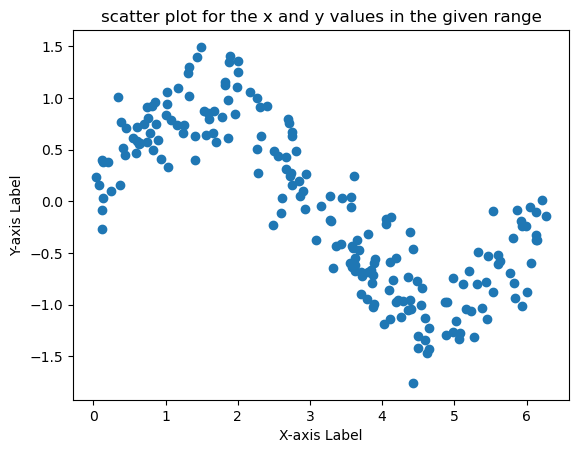

In [76]:
#createing a scatter plot
plt.scatter(X_SAMPLES, Y_SAMPLES)
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('scatter plot for the x and y values in the given range')
plt.show()

In [77]:
#defining non linear activation functions 
#defining the first sigmoid function by using the lambda to get [1/(1+e^-x)]
sigmoid = lambda x: 1 / (1 + np.exp(-x))
#identity function to return x 
#this will be used in the final layer 
identity = lambda x: x

In [78]:
#initailization of weights, biases and activation function
weight_matrices = []
bias_vectors = []
activation_functions = []
#iterate over the weight and bias for this it will itterate over the layer transition
for (fan_in,fan_out) in zip(LAYERS[:-1],LAYERS[1:]):
    #using the zip will skip the first and the last element in the list
    #finding the limit for the Xavier Glorot Uniform init
    #which is 6(1+10) = 6/11
    limit = np.sqrt(6/(fan_in+fan_out)) 
    #Xavier Glorot Uniform init
    W = np.random.uniform(
    low = -limit,
    high = +limit,
    size = (fan_in,fan_out),
    )
    #zero bias initialization
    b = np.zeros(fan_out)
    #adding to weight matrix
    weight_matrices.append(W)
    #adding bias to bias vector
    bias_vectors.append(b)
    #adding sigmoid for each layer to activation function except the last layer it will be used as identity
    #sigmoid function by using the lambda to get [1/(1+e^-x)]
    activation_functions.append(sigmoid)
#making the last one as identity
#identity to return x 
#this will be used in the final layer
activation_functions[-1] = identity

In [79]:
# Define the forward pass function
def forward_pass(x, weights, biases, activations):
    a = x

    for W, b, f in zip(weights, biases, activations):
        #Multiply the matrix a with the weight matrix
        a = a @ W
        #Adding the biases to a
        a = a + b
        #Apply the activation function
        a = f(a)

    return a

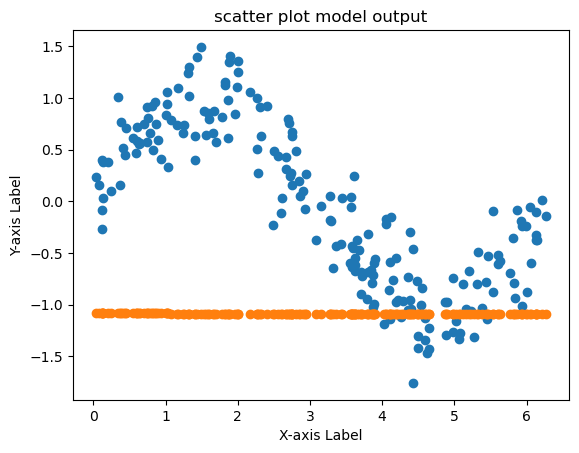

In [80]:
#createing a scatter plot
plt.scatter(X_SAMPLES, Y_SAMPLES)
plt.scatter(X_SAMPLES, forward_pass(X_SAMPLES, weight_matrices, bias_vectors, activation_functions))
plt.title('scatter plot model output')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.show()

In [81]:
#implementing forward loss function
def loss_forward(y_guess, y_ref):
    delta = y_guess - y_ref
    return 0.5 * np.mean(delta**2)

In [82]:
#checking to function for forward loss
loss_forward(
    forward_pass(X_SAMPLES, weight_matrices, bias_vectors, activation_functions),
    Y_SAMPLES,
)

0.8150125501544491

In [83]:
#implementing backward loss function
def loss_backward(y_guess, y_ref):
    delta = y_guess - y_ref
    N = delta.size
    return delta / N

In [84]:
def network_forward_and_backward(x, y_ref, weights, biases, activations, activations_derivatives):
    #Initialize the activated state 'a' with the input data 'x'
    a = x
    #Store the intermediate activated states for the backward pass
    layer_states = [a, ]
    #Iterate through each layer defined by weights, biases, and activation functions
    for W, b, f in zip(weights, biases, activations):
        #Perform a linear transformation by multiplying 'a' with the weight matrix 'W'
        a = a @ W
        #Add the bias vector 'b' to the result of the linear transformation
        a = a + b
        #Apply the activation function 'f' to the result
        a = f(a)
        #Store the current activated state in the layer_states list
        layer_states.append(a)
        
    #The final activated state 'y' is the output of the network
    y = a
    #Calculate the loss between the predicted output 'y' and the reference 'y_ref'
    loss = loss_forward(y, y_ref)
    # Calculate the initial cotangent for the backward pass
    current_cotangent = loss_backward(y, y_ref)
    #Initialize lists to store gradients for weights and biases
    weight_gradients = []
    bias_gradients = []
    #Iterate through the layers in reverse order
    for W, f_prime, a_current, a_prev in zip(
        reversed(weights),
        reversed(activations_derivatives),
        reversed(layer_states[1:]),
        reversed(layer_states[:-1]),
    ):
        #Compute the cotangent for the activated state of the current layer
        activated_state_cotangent = current_cotangent
        #Multiply the cotangent by the derivative of the activation function
        plus_bias_state_cotangent = activated_state_cotangent * f_prime(a_current)
        #Calculate the gradient for the bias vector
        bias_grad = np.sum(plus_bias_state_cotangent, axis=0)
        #Update the state cotangent for the previous layer
        state_cotangent = plus_bias_state_cotangent
        #Calculate the gradient for the weight matrix
        prev_activated_state_cotangent = state_cotangent @ W.T
        weight_grad = a_prev.T @state_cotangent
        # Append the bias and weight gradients to their respective lists
        bias_gradients.append(bias_grad)
        weight_gradients.append(weight_grad)
        # Update the current cotangent for the next iteration (previous layer)
        current_cotangent = prev_activated_state_cotangent
    # Return the loss, reversed weight gradients, and reversed bias gradients
    return loss, reversed(weight_gradients),reversed(bias_gradients)

In [85]:
sigmoid_prime = lambda x_activated:x_activated*(1-x_activated)
identity_prime = lambda x_activated:1

In [86]:
activation_functions_derivatives= [sigmoid_prime,]*(len(LAYERS)-2)+[identity_prime,]
activation_functions_derivatives

[<function __main__.<lambda>(x_activated)>,
 <function __main__.<lambda>(x_activated)>,
 <function __main__.<lambda>(x_activated)>,
 <function __main__.<lambda>(x_activated)>]

In [87]:
network_forward_and_backward(
    X_SAMPLES,
    Y_SAMPLES,
    weight_matrices,
    bias_vectors,
    activation_functions,
    activation_functions_derivatives,
)

(0.8150125501544491,
 <list_reverseiterator at 0x10cfed3f0>)

In [88]:
#training loop 

loss_history =[]
for epoch in range(N_EPOCH):
    loss, weight_gradients,bias_gradients = network_forward_and_backward(
        X_SAMPLES,
        Y_SAMPLES,
        weight_matrices,
        bias_vectors,
        activation_functions,
        activation_functions_derivatives,
    )
    for W,W_grad,b,b_grad in zip(
        weight_matrices,
        weight_gradients,
        bias_vectors,
        bias_gradients,
    ):
        W -= LEARNING_RATE * W_grad
        b -= LEARNING_RATE * b_grad
    if epoch % 100 ==0:
        print(f"Epoch{epoch},loss:{loss}")
    loss_history.append(loss)
    
        

Epoch0,loss:0.8150125501544491
Epoch100,loss:0.29640474308066517
Epoch200,loss:0.29340716885020623
Epoch300,loss:0.28968932959871335
Epoch400,loss:0.28472152706379333
Epoch500,loss:0.27772642713267875
Epoch600,loss:0.26740234545758534
Epoch700,loss:0.2515105937008521
Epoch800,loss:0.22678861106218215
Epoch900,loss:0.19165968019714924
Epoch1000,loss:0.15509645594585478
Epoch1100,loss:0.13315255132450818
Epoch1200,loss:0.12471290993411227
Epoch1300,loss:0.12140545142217668
Epoch1400,loss:0.11972863803515912
Epoch1500,loss:0.11863326629802148
Epoch1600,loss:0.11776004773313563
Epoch1700,loss:0.1169676080600367
Epoch1800,loss:0.11619454645358979
Epoch1900,loss:0.1154117251921301
Epoch2000,loss:0.1146037698638225
Epoch2100,loss:0.1137614271036132
Epoch2200,loss:0.11287832640323579
Epoch2300,loss:0.11194957800096679
Epoch2400,loss:0.11097111826590371
Epoch2500,loss:0.10993934645364725
Epoch2600,loss:0.10885089361490952
Epoch2700,loss:0.10770254292123646
Epoch2800,loss:0.10649148738689673
Epo

Epoch23800,loss:0.04188959237674732
Epoch23900,loss:0.04220941581116214
Epoch24000,loss:0.05358599198829474
Epoch24100,loss:0.043382679001420864
Epoch24200,loss:0.041938216386858435
Epoch24300,loss:0.0418539871135796
Epoch24400,loss:0.04187333818820181
Epoch24500,loss:0.04256256909915242
Epoch24600,loss:0.05140297251484664
Epoch24700,loss:0.04325054370746202
Epoch24800,loss:0.04194177539312923
Epoch24900,loss:0.04184725530322118
Epoch25000,loss:0.04200496189876382
Epoch25100,loss:0.04437677506665809
Epoch25200,loss:0.047729587894216205
Epoch25300,loss:0.042486416470146844
Epoch25400,loss:0.04190877355214807
Epoch25500,loss:0.04192411546322245
Epoch25600,loss:0.04272493729983244
Epoch25700,loss:0.04730856806392254
Epoch25800,loss:0.043847795911705394
Epoch25900,loss:0.0421079452910115
Epoch26000,loss:0.04193265140648737
Epoch26100,loss:0.04230079106901163
Epoch26200,loss:0.04483475962272853
Epoch26300,loss:0.04530298223806318
Epoch26400,loss:0.042511167912608394
Epoch26500,loss:0.042001

Epoch47900,loss:0.041337264508145406
Epoch48000,loss:0.041331259676956764
Epoch48100,loss:0.041325218685010816
Epoch48200,loss:0.04132040726891034
Epoch48300,loss:0.04131756538374908
Epoch48400,loss:0.041316700096043046
Epoch48500,loss:0.04131712415543713
Epoch48600,loss:0.04131770879353991
Epoch48700,loss:0.04131729373635262
Epoch48800,loss:0.041315129925444706
Epoch48900,loss:0.04131116759282752
Epoch49000,loss:0.04130604558213505
Epoch49100,loss:0.04130079701260336
Epoch49200,loss:0.041296434637637935
Epoch49300,loss:0.04129360045663002
Epoch49400,loss:0.041292382525893866
Epoch49500,loss:0.041292318079296154
Epoch49600,loss:0.041292563605196425
Epoch49700,loss:0.041292190230266396
Epoch49800,loss:0.0412905201130272
Epoch49900,loss:0.04128737547119028
Epoch50000,loss:0.041283126948396254
Epoch50100,loss:0.041278523134328345
Epoch50200,loss:0.041274393492438104
Epoch50300,loss:0.04127135876925369
Epoch50400,loss:0.04126964521593612
Epoch50500,loss:0.0412690373441072
Epoch50600,loss:0

Epoch72000,loss:0.040999253731107126
Epoch72100,loss:0.04099845708557167
Epoch72200,loss:0.040997647249360225
Epoch72300,loss:0.0409968345099705
Epoch72400,loss:0.04099602984106319
Epoch72500,loss:0.04099524283620154
Epoch72600,loss:0.04099447998125036
Epoch72700,loss:0.04099374356657192
Epoch72800,loss:0.04099303140868135
Epoch72900,loss:0.0409923373986108
Epoch73000,loss:0.04099165274702542
Epoch73100,loss:0.04099096767698574
Epoch73200,loss:0.04099027324246233
Epoch73300,loss:0.04098956293636175
Epoch73400,loss:0.04098883379912259
Epoch73500,loss:0.04098808683971423
Epoch73600,loss:0.04098732671546172
Epoch73700,loss:0.040986560757873845
Epoch73800,loss:0.04098579754973065
Epoch73900,loss:0.04098504533153657
Epoch74000,loss:0.040984310532045584
Epoch74100,loss:0.040983596679627435
Epoch74200,loss:0.040982903870662175
Epoch74300,loss:0.04098222886551792
Epoch74400,loss:0.040981565771112866
Epoch74500,loss:0.04098090716944413
Epoch74600,loss:0.040980245478874286
Epoch74700,loss:0.0409

Epoch96100,loss:0.040868140418164015
Epoch96200,loss:0.04086774473566979
Epoch96300,loss:0.04086734899690101
Epoch96400,loss:0.040866953333027825
Epoch96500,loss:0.040866557956129285
Epoch96600,loss:0.040866163131586114
Epoch96700,loss:0.04086576914500905
Epoch96800,loss:0.04086537626775236
Epoch96900,loss:0.04086498472508909
Epoch97000,loss:0.040864594670686254
Epoch97100,loss:0.0408642061701634
Epoch97200,loss:0.04086381919537017
Epoch97300,loss:0.04086343362972694
Epoch97400,loss:0.040863049283677205
Epoch97500,loss:0.040862665918162
Epoch97600,loss:0.04086228327316491
Epoch97700,loss:0.040861901097880106
Epoch97800,loss:0.040861519178973606
Epoch97900,loss:0.04086113736373443
Epoch98000,loss:0.04086075557559758
Epoch98100,loss:0.040860373820477684
Epoch98200,loss:0.04085999218345554
Epoch98300,loss:0.04085961081648223
Epoch98400,loss:0.04085922991877882
Epoch98500,loss:0.04085884971238984
Epoch98600,loss:0.04085847041582533
Epoch98700,loss:0.040858092218853025
Epoch98800,loss:0.040

Epoch118300,loss:0.040793813912497645
Epoch118400,loss:0.04079351793775287
Epoch118500,loss:0.04079322221031461
Epoch118600,loss:0.04079292673601163
Epoch118700,loss:0.04079263151482615
Epoch118800,loss:0.040792336540888596
Epoch118900,loss:0.04079204180299195
Epoch119000,loss:0.04079174728556742
Epoch119100,loss:0.040791452970022915
Epoch119200,loss:0.04079115883631808
Epoch119300,loss:0.04079086486462996
Epoch119400,loss:0.04079057103696122
Epoch119500,loss:0.04079027733854926
Epoch119600,loss:0.04078998375895844
Epoch119700,loss:0.040789690292766335
Epoch119800,loss:0.04078939693979402
Epoch119900,loss:0.040789103704871224
Epoch120000,loss:0.040788810597169205
Epoch120100,loss:0.04078851762916884
Epoch120200,loss:0.0407882248153655
Epoch120300,loss:0.04078793217082779
Epoch120400,loss:0.040787639709742224
Epoch120500,loss:0.04078734744406898
Epoch120600,loss:0.040787055382425
Epoch120700,loss:0.040786763529283586
Epoch120800,loss:0.040786471884555385
Epoch120900,loss:0.0407861804435

Epoch142300,loss:0.040725490537112455
Epoch142400,loss:0.040725207852150246
Epoch142500,loss:0.04072492512421019
Epoch142600,loss:0.04072464235412607
Epoch142700,loss:0.04072435954252329
Epoch142800,loss:0.040724076689734226
Epoch142900,loss:0.040723793795737526
Epoch143000,loss:0.040723510860124004
Epoch143100,loss:0.04072322788209116
Epoch143200,loss:0.0407229448604665
Epoch143300,loss:0.040722661793756866
Epoch143400,loss:0.04072237868022002
Epoch143500,loss:0.040722095517952805
Epoch143600,loss:0.040721812304988954
Epoch143700,loss:0.04072152903939928
Epoch143800,loss:0.040721245719387913
Epoch143900,loss:0.04072096234337633
Epoch144000,loss:0.04072067891007061
Epoch144100,loss:0.040720395418506895
Epoch144200,loss:0.04072011186807262
Epoch144300,loss:0.0407198282585023
Epoch144400,loss:0.040719544589848417
Epoch144500,loss:0.04071926086243094
Epoch144600,loss:0.040718977076768775
Epoch144700,loss:0.04071869323349869
Epoch144800,loss:0.04071840933328739
Epoch144900,loss:0.040718125

Epoch164600,loss:0.040660436180056506
Epoch164700,loss:0.040660131746138556
Epoch164800,loss:0.04065982717255421
Epoch164900,loss:0.04065952245893875
Epoch165000,loss:0.040659217604893626
Epoch165100,loss:0.040658912609993214
Epoch165200,loss:0.04065860747379409
Epoch165300,loss:0.040658302195844646
Epoch165400,loss:0.04065799677569535
Epoch165500,loss:0.04065769121290861
Epoch165600,loss:0.04065738550706799
Epoch165700,loss:0.04065707965778552
Epoch165800,loss:0.04065677366470768
Epoch165900,loss:0.04065646752751878
Epoch166000,loss:0.04065616124594212
Epoch166100,loss:0.040655854819738796
Epoch166200,loss:0.040655548248704126
Epoch166300,loss:0.04065524153266201
Epoch166400,loss:0.04065493467145801
Epoch166500,loss:0.04065462766495089
Epoch166600,loss:0.04065432051300382
Epoch166700,loss:0.04065401321547513
Epoch166800,loss:0.04065370577221045
Epoch166900,loss:0.04065339818303506
Epoch167000,loss:0.04065309044774773
Epoch167100,loss:0.040652782566116805
Epoch167200,loss:0.04065247453

Epoch188400,loss:0.040583481918120494
Epoch188500,loss:0.04058313765654622
Epoch188600,loss:0.0405827932077465
Epoch188700,loss:0.040582448571599976
Epoch188800,loss:0.04058210374798893
Epoch188900,loss:0.04058175873679998
Epoch189000,loss:0.04058141353792427
Epoch189100,loss:0.04058106815125767
Epoch189200,loss:0.04058072257670085
Epoch189300,loss:0.040580376814158436
Epoch189400,loss:0.04058003086353906
Epoch189500,loss:0.04057968472475428
Epoch189600,loss:0.04057933839771801
Epoch189700,loss:0.04057899188234525
Epoch189800,loss:0.04057864517855176
Epoch189900,loss:0.04057829828625261
Epoch190000,loss:0.04057795120536183
Epoch190100,loss:0.040577603935791504
Epoch190200,loss:0.04057725647745133
Epoch190300,loss:0.04057690883024822
Epoch190400,loss:0.040576560994086325
Epoch190500,loss:0.04057621296886678
Epoch190600,loss:0.04057586475448833
Epoch190700,loss:0.04057551635084767
Epoch190800,loss:0.040575167757839876
Epoch190900,loss:0.04057481897535931
Epoch191000,loss:0.04057447000330

Epoch211900,loss:0.04049728563836062
Epoch212000,loss:0.0404968958165631
Epoch212100,loss:0.04049650579964699
Epoch212200,loss:0.04049611558764129
Epoch212300,loss:0.040495725180575357
Epoch212400,loss:0.04049533457847893
Epoch212500,loss:0.04049494378138216
Epoch212600,loss:0.04049455278931577
Epoch212700,loss:0.040494161602311306
Epoch212800,loss:0.04049377022040104
Epoch212900,loss:0.04049337864361812
Epoch213000,loss:0.0404929868719965
Epoch213100,loss:0.04049259490557093
Epoch213200,loss:0.040492202744377134
Epoch213300,loss:0.04049181038845173
Epoch213400,loss:0.040491417837831965
Epoch213500,loss:0.040491025092555796
Epoch213600,loss:0.040490632152661805
Epoch213700,loss:0.04049023901818907
Epoch213800,loss:0.040489845689177045
Epoch213900,loss:0.04048945216566542
Epoch214000,loss:0.0404890584476943
Epoch214100,loss:0.04048866453530369
Epoch214200,loss:0.040488270428533805
Epoch214300,loss:0.04048787612742499
Epoch214400,loss:0.0404874816320174
Epoch214500,loss:0.040487086942351

Epoch235800,loss:0.04039868439455921
Epoch235900,loss:0.040398249538470925
Epoch236000,loss:0.04039781450233354
Epoch236100,loss:0.04039737928621458
Epoch236200,loss:0.040396943890181614
Epoch236300,loss:0.040396508314301534
Epoch236400,loss:0.040396072558641236
Epoch236500,loss:0.04039563662326729
Epoch236600,loss:0.04039520050824593
Epoch236700,loss:0.040394764213643415
Epoch236800,loss:0.040394327739525525
Epoch236900,loss:0.040393891085957756
Epoch237000,loss:0.040393454253005584
Epoch237100,loss:0.040393017240734075
Epoch237200,loss:0.04039258004920788
Epoch237300,loss:0.04039214267849173
Epoch237400,loss:0.040391705128649855
Epoch237500,loss:0.040391267399745995
Epoch237600,loss:0.04039082949184383
Epoch237700,loss:0.04039039140500656
Epoch237800,loss:0.040389953139297045
Epoch237900,loss:0.040389514694777445
Epoch238000,loss:0.04038907607151003
Epoch238100,loss:0.04038863726955611
Epoch238200,loss:0.040388198288977044
Epoch238300,loss:0.040387759129833355
Epoch238400,loss:0.0403

Epoch257800,loss:0.0402987488171804
Epoch257900,loss:0.04029827497150315
Epoch258000,loss:0.040297800944061005
Epoch258100,loss:0.04029732673472095
Epoch258200,loss:0.0402968523433487
Epoch258300,loss:0.04029637776980823
Epoch258400,loss:0.04029590301396206
Epoch258500,loss:0.04029542807567113
Epoch258600,loss:0.0402949529547948
Epoch258700,loss:0.04029447765119101
Epoch258800,loss:0.040294002164716146
Epoch258900,loss:0.04029352649522494
Epoch259000,loss:0.04029305064257075
Epoch259100,loss:0.04029257460660531
Epoch259200,loss:0.04029209838717884
Epoch259300,loss:0.04029162198413989
Epoch259400,loss:0.04029114539733568
Epoch259500,loss:0.04029066862661157
Epoch259600,loss:0.040290191671811415
Epoch259700,loss:0.04028971453277747
Epoch259800,loss:0.04028923720935062
Epoch259900,loss:0.040288759701369956
Epoch260000,loss:0.04028828200867311
Epoch260100,loss:0.04028780413109605
Epoch260200,loss:0.04028732606847298
Epoch260300,loss:0.04028684782063673
Epoch260400,loss:0.040286369387418544

Epoch281800,loss:0.04017930157740867
Epoch281900,loss:0.04017877686005713
Epoch282000,loss:0.04017825188858795
Epoch282100,loss:0.04017772666260342
Epoch282200,loss:0.04017720118170613
Epoch282300,loss:0.040176675445499146
Epoch282400,loss:0.04017614945358591
Epoch282500,loss:0.040175623205570325
Epoch282600,loss:0.04017509670105643
Epoch282700,loss:0.0401745699396493
Epoch282800,loss:0.04017404292095411
Epoch282900,loss:0.040173515644576614
Epoch283000,loss:0.040172988110123195
Epoch283100,loss:0.0401724603172007
Epoch283200,loss:0.04017193226541647
Epoch283300,loss:0.04017140395437876
Epoch283400,loss:0.040170875383696146
Epoch283500,loss:0.040170346552978076
Epoch283600,loss:0.040169817461834414
Epoch283700,loss:0.04016928810987594
Epoch283800,loss:0.04016875849671415
Epoch283900,loss:0.04016822862196108
Epoch284000,loss:0.04016769848522974
Epoch284100,loss:0.0401671680861339
Epoch284200,loss:0.040166637424288
Epoch284300,loss:0.04016610649930733
Epoch284400,loss:0.04016557531080814

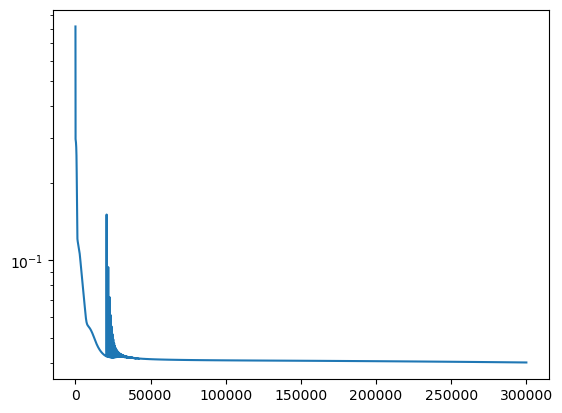

In [89]:
plt.plot(loss_history)
plt.yscale("log")

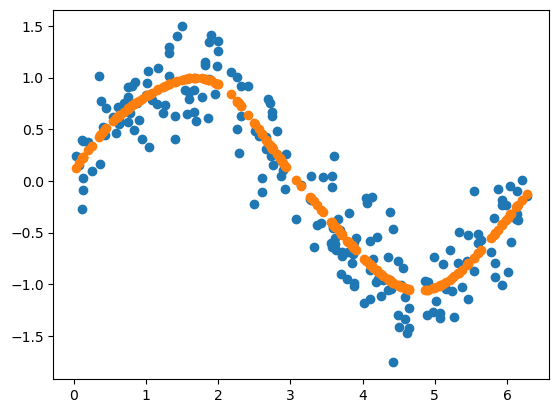

In [90]:
plt.scatter(X_SAMPLES, Y_SAMPLES)
plt.scatter(X_SAMPLES, forward_pass(X_SAMPLES, weight_matrices, bias_vectors, activation_functions))